In [9]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import dlib


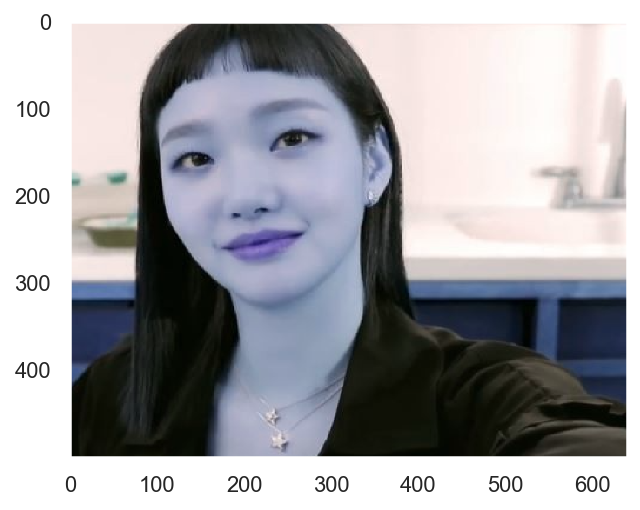

In [431]:
my_image_path = os.getcwd()+'/images/image_03.png'

img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 500))    # 640x ?? 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관

plt.imshow(img_bgr)
plt.grid(False)
plt.show()

# 얼굴 검출 (face detection)

In [432]:
# dlib을 활용해 hog detector를 선언
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

dlib 의 face detector는 HOG(Histogram of Oriented Gradient) feature를    
사용해서 SVM(Support Vector Machine)의 sliding window로 얼굴을 찾는다.

In [433]:
# detector를 이용해서 얼굴의 bounding box를 추출.
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

dlib detector 는 dlib.rectangles 타입의 객체를 반환   
dlib.rectangles 는 dlib.rectangle 객체의 배열 형태로 이루어짐.   
dlib.rectangle 객체는 left(), top(), right(), bottom(), height(), width()

rectangles[[(92, 68) (315, 291)]]


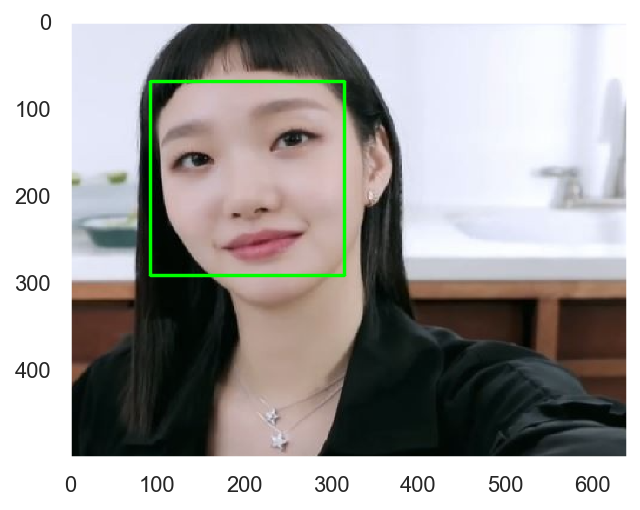

In [434]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top() 
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) # 녹색으로

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.grid(False)
plt.show()

# 얼굴 랜드마크(fade landmark)
- 이목구비의 위치를 추론하는 것을 face landmark localization 기술이라 한다. 
- face landmark는 detection의 결과물인 bounding box 로 잘라낸(crop) 얼굴 이미지를 이용한다.   
   
 
### [ Object keypoint estimation 알고리즘 ]   
Face landmark와 같이 객체 내부의 점을 찾는 기술을 object keypoint estimation이라고 한다.       
1) top-down : bounding box를 찾고 box 내부의 keypoint를 예측   
2) bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성

점 68개를 사용하는 ibug를 이용한다. Dlib은 ibug 300-W 데이터셋으로 학습한 pretrained model 을 제공한다.

In [435]:
# 저장한 landmark 모델을 불러온다
model_path = os.getcwd()+'/model/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [436]:
# landmark_predictor는 RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환한다.
# points는 dlib.full_object_detection 의 객체이기 때문에 parts() 함수로 개별 위치에 접근할 수 있다.

list_landmarks = []

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


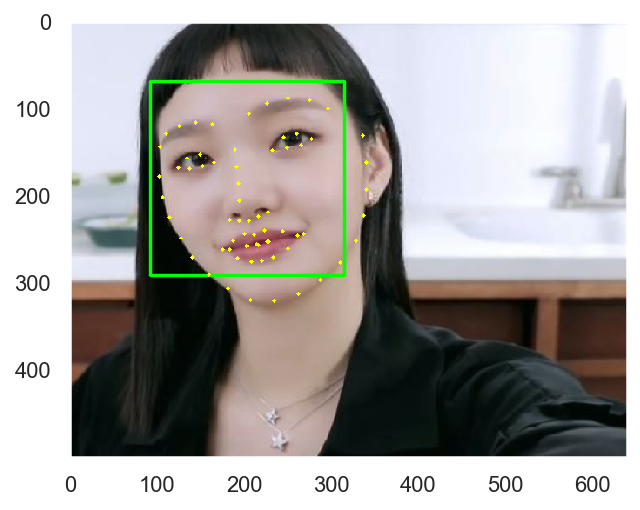

In [437]:
# 랜드마크를 영상에 출력해 보겠습니다.

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.grid(False)
plt.show()

# 스티커 적용하기
스티커를 적용하기 앞서서 고려해야될점 2가지를 짚고가자.
1. 스티커 위치 : 
2. 스티커 크기 : weight = height

In [438]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # left eye bottom index : 40
    x = landmark[40][0] 
    y = landmark[40][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(194, 205)
(x,y) : (152,165)
(w,h) : (224,224)


(224, 224, 3)


<function matplotlib.pyplot.show(*args, **kw)>

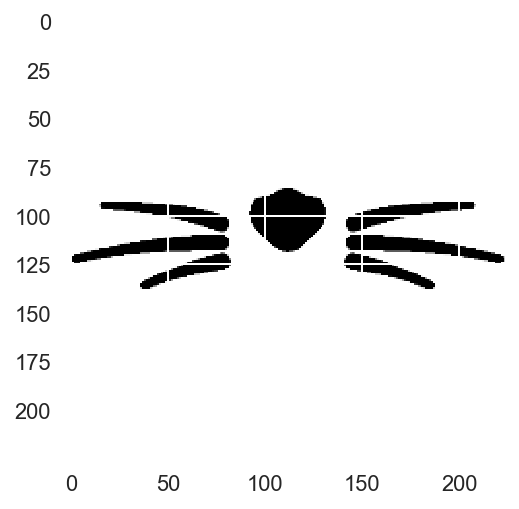

In [439]:
# 준비해 둔 스티커 이미지를 읽어서 적용하기.

sticker_path = os.getcwd()+'/images/cat-whiskers.png'

img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

img_sticker_rgb = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)
plt.imshow(img_sticker_rgb)
plt.show

In [440]:
# 원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정한다. 
# 이미지 시작점은 top-left 좌표이다.

refined_x = x - w // 3 # left
refined_y = y - h // 3 # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (78,91)


In [441]:
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:]
    refined_y = 0

In [442]:
# 원본 이미지에 스티커를 적용
# sticker_area는 원본이미지에서 스티커를 적용할 위치를 crop한 이미지 
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

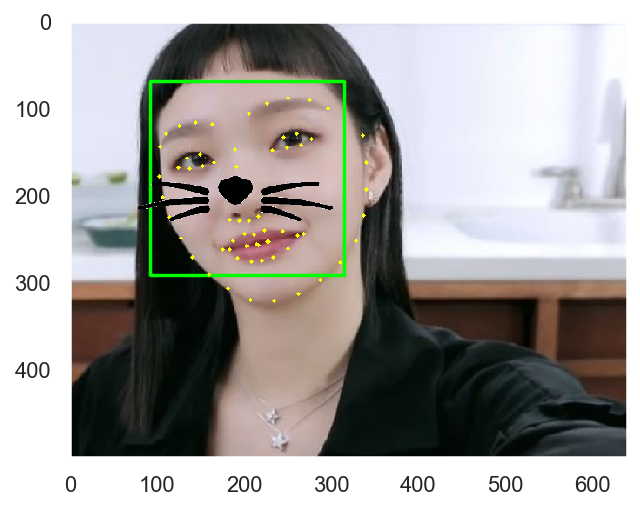

In [443]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.grid(False)
plt.show()

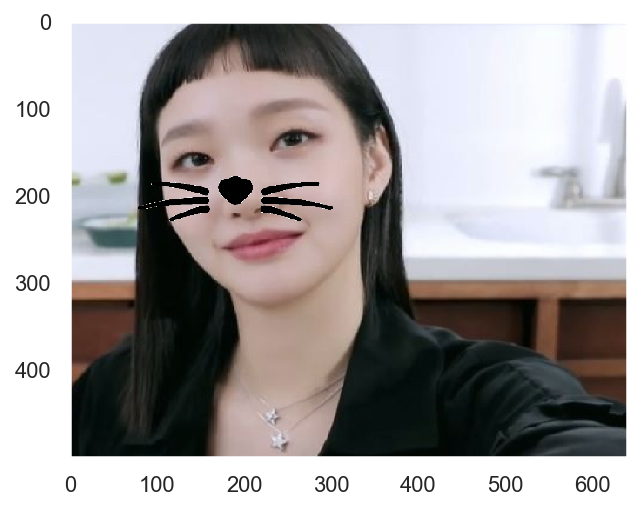

In [444]:
# bounding box와 landmark를 제거하고 최종 결과만 출력해 보자. 
# img_show 대신 img_rgb를 활용해보자.

sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.grid(False)
plt.show()

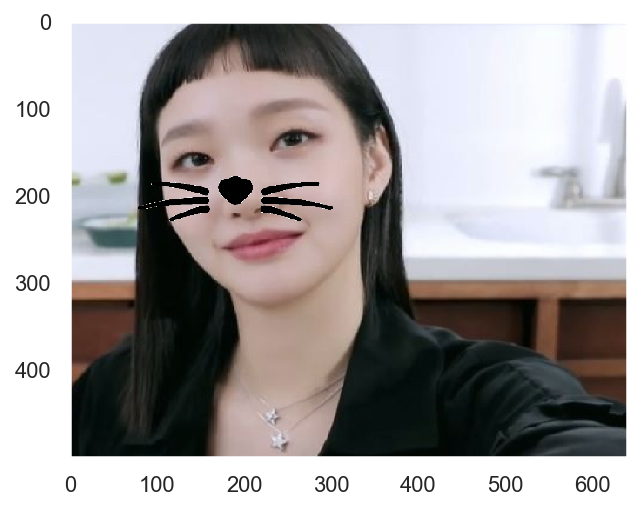

In [445]:
# 스티커 투명하게 적용하기


sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    cv2.addWeighted(sticker_area, 0.3, np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8), 0.7, 0)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.grid(False)
plt.show()